<a href="https://colab.research.google.com/github/taceroc/DSPS_TAcero/blob/main/hw3/Copy_of_KS_earthquakes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Created by FedericaBBianco @fedhere for DSPS/MLNPS
# Kolmogorov Smirnoff test, application to earthquake data

In [1]:
#all the imports I needed
from __future__ import print_function, division
import pandas as pd
import pylab as pl
import scipy as sp
from scipy import stats
%pylab inline
pl.style.use("https://raw.githubusercontent.com/fedhere/DSPS/master/fbb.mplstyle")

Populating the interactive namespace from numpy and matplotlib


This homework asks you to reproduce the work in [Corral 2018](https://arxiv.org/pdf/0910.0055.pdf) which is well described, but not "reproducible". 
Corral 2018 uses a K-S test to show that at different magnitude scales the time gaps between earthquakes follows the same distribution. If true, this indicates that there is a consistent scaling law. 

The argument is a little convoluted, but it is a somewhat innovative use of the test. Corall compares the time gap between earthquakes  greater than a certain magnitude threshold with the time gaps between earthquakes above a different threshold, and finds no differences.

Remind yourself exactly what the K-S test is about :

    1 What is the test's Null Hypothsis that the K-S test tests?
    
    


The data that you have came from the same distribution




    2 What is the "statistic" or "pivotal quantity" that the test uses?
    


Maximum difference or distance between the cumulative distributions:
\begin{equation}
    D = max|F_2(x_2)-F_1(x_1)|
\end{equation}

where F$_2$ and F$_1$ are the cumulative distributions and x$_2$ and x$_1$ are the data or the two samples.


    3 What does the probability distribution of this statistic depend on? 
    
   


On the number of data points and the distance between the cumulative distributions.


    

# Data Retrival

The first reason why the paper is not techincally _reproducible_ is that, while a link is provided to retrieve the data, the link is dead. This happens often. Services like [Zenodo](https://zenodo.org/) or journals that serve data provide some insurance against this but unfortunately the standards are not strict. 

You can retrieve the data yourself from [this website](http://service.scedc.caltech.edu/eq-catalogs/poly.php). Think about what setting up data like this means for reproducibility. Did the author comply to reproducibility standards?__ Make sure the number of entries in your final dataset is similar to that of the authors. I got 70798, instead of 77000. 10% off, which I deem close enough. You should get something similar. Use the map in the paper to determine the region of interest. Call the file earthquakes_\<firstinitialLastname\>.csv and upload it to your github repository. Read it your file, instead of mine as instructed below. If you are getting weird results compare to what I got, go back and check how the files differ.

# Data Ingestion

## read in data

I saved the data in a file called "earthquakes.csv", where ```csv``` stands for "comma separated file". [This file format](https://www.howtogeek.com/348960/what-is-a-csv-file-and-how-do-i-open-it/) requires different entries in a row to be separated by commas alone (no space) and for commas to be used in quote if they are not intended to separate entries. 

```
a,b,c
d,e,f
g,"h,2",i
```
The data is uploaded on the  github homework repository but to read it in you will need to get the link to the *raw file*: the link to the file earthquakes.csv which is in my GitHub repository https://github.com/fedhere/MLPNS2021/tree/main/HW2_NHRT takes you to an ```html``` page that includes the content of the file, but you want to isolate the content of the file itself: the _raw file_. Pay attention to this: from the next time I will not give you the exact link, I will just point you to the file and you will have to find the link to the raw data from there. (remember to use the "raw" link)

The data can be read effectively using the _pandas_ python package as ```pandas.read_csv(<file name or URL>)```. 

However, I did not format the data correctly, according to the csv extension requirement. This happens all the time. Look at the file and use the pandas documentation to figure out how to read it with ```pd.read_csv()```

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
eqdata = pd.read_csv('https://github.com/fedhere/DSPS_FBianco/blob/master/HW3/earthquakes.csv?raw=true', sep = " ")

running the following lines of code should give you the same result as mine if you used the file I provided (467 students), and qualitatively  similar if you are using your own data (667 students)

In [4]:
eqdata.shape

(70798, 34)

In [5]:
eqdata.head()

,#YYY/MM/DD,HH:mm:SS.ss,ET,GT,MAG,Unnamed: 5,M,Unnamed: 7,Unnamed: 8,Unnamed: 9,LAT,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,LON,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,DEPTH,Q,Unnamed: 25,EVID,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,NPH,NGRM
0,1984/01/01,01:30:57.52,eq,NaN,l,2.02,c,NaN,NaN,33.246,-116.433,NaN,NaN,1.6,C,NaN,NaN,NaN,28255.0,NaN,NaN,13.0,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1984/01/01,05:31:34.16,eq,NaN,l,2.12,c,NaN,NaN,32.945,-116.295,NaN,NaN,5.4,C,NaN,NaN,NaN,28259.0,NaN,NaN,18.0,NaN,NaN,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1984/01/01,06:59:05.14,eq,NaN,l,2.43,c,NaN,NaN,33.343,-117.628,NaN,NaN,5.6,C,NaN,NaN,NaN,28260.0,NaN,NaN,13.0,NaN,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1984/01/01,11:10:25.29,eq,NaN,l,2.07,c,NaN,NaN,33.668,-116.780,NaN,13.8,C,NaN,NaN,NaN,28270.0,NaN,NaN,19.0,NaN,NaN,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1984/01/01,19:38:19.79,eq,NaN,l,2.13,c,NaN,NaN,33.963,-116.290,NaN,NaN,2.7,C,NaN,NaN,NaN,28553.0,NaN,NaN,40.0,NaN,NaN,49.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
eqdata.describe()

,GT,Unnamed: 5,Unnamed: 7,Unnamed: 8,Unnamed: 9,LAT,Unnamed: 11,Unnamed: 12,Unnamed: 15,Unnamed: 16,LON,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,DEPTH,Q,Unnamed: 25,EVID,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,NPH,NGRM
count,0.0,70798.000000,0.0,0.0,70798.000000,70798.00000,0.0,9648.000000,7.359000e+03,4.628900e+04,14096.000000,10889.000000,43932.000000,21302.000000,33735.000000,18080.000000,12705.000000,3387.000000,469.000000,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,2.417826,NaN,NaN,33.977749,-116.88145,NaN,13.354343,6.097558e+06,4.482677e+06,524649.772205,16307.082193,43.634321,141.903530,203.562443,78.426383,55.085714,43.415412,14.746269,7.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,0.407683,NaN,NaN,1.156586,1.07667,NaN,2.724517,4.441852e+06,3.130379e+06,281055.136911,25237.230734,121.795817,311.415589,155.337382,56.105321,30.519535,24.266088,17.013243,2.828427,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,2.000000,NaN,NaN,30.094830,-121.76000,NaN,10.000000,1.000432e+06,1.070000e+02,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,2.120000,NaN,NaN,33.061000,-117.69200,NaN,11.200000,3.041641e+06,3.031237e+06,136998.250000,27.000000,18.000000,14.000000,113.000000,48.000000,33.000000,24.000000,0.000000,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,2.300000,NaN,NaN,34.056750,-116.59000,NaN,12.800000,3.229114e+06,3.110080e+06,703081.500000,57.000000,28.000000,23.000000,168.000000,70.000000,50.000000,38.000000,13.000000,7.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,2.590000,NaN,NaN,34.591000,-116.25100,NaN,14.900000,9.669999e+06,9.027968e+06,725926.500000,37764.000000,42.000000,137.000000,294.000000,92.000000,71.000000,61.000000,24.000000,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,7.100000,NaN,NaN,37.985500,-113.71900,NaN,29.300000,3.736673e+07,9.875061e+06,754723.000000,71774.000000,3384.000000,3815.000000,1574.000000,996.000000,227.000000,145.000000,88.000000,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


now that you have a dataframe object you can use methods of the object to modify it. Use the method ```eqdata.rename``` to change the names of the 3 columns that are the only three relevant to us: _date, time, magnitude_

## prepare date-time column

In [7]:
eqdata = eqdata[['#YYY/MM/DD', 'HH:mm:SS.ss', 'Unnamed: 5']].rename({'#YYY/MM/DD':'date', 'HH:mm:SS.ss':'time',
                                                            'Unnamed: 5':'mag'}, axis=1)

In [8]:
eqdata.head()

,date,time,mag
0,1984/01/01,01:30:57.52,2.02
1,1984/01/01,05:31:34.16,2.12
2,1984/01/01,06:59:05.14,2.43
3,1984/01/01,11:10:25.29,2.07
4,1984/01/01,19:38:19.79,2.13


In [9]:
eqdata.describe()

,mag
count,70798.000000
mean,2.417826
std,0.407683
min,2.000000
25%,2.120000
50%,2.300000
75%,2.590000
max,7.100000


Now you want to combine the columns containing date and time and convert them to a "datetime" kind of data object. 


What data type are the _time_ and _date_ columns right now? What type you want them to be to conver them to datetime with ```pd.datetime()```? type 'O' means object, typically a string. 

In [10]:
eqdata.time.dtype, eqdata.date.dtype

(dtype('O'), dtype('O'))

to do this conversion I 

   1. joined date and time into a single string for each row with a ["list comprehension"](https://www.pythonforbeginners.com/basics/list-comprehensions-in-python) (essentially a for loop but more efficient and compact). You do not have to do it with a list comprehension, you can use just a for loop.

   2. used pd.datetime() to convert the resulting new dataframe column into a dataframe column containing _datetime_ objects (see lab)

   3. but this did not work because of the formatting of some dates, so I had to go back and fix 5 entries. (you are on your own to figure out this one)

In [11]:
# -- combine data and time: I just combined the columns instead of a loop, is correct?
eqdata["datetime"] = eqdata["date"]+" "+eqdata["time"]
# -- replace the 60.00 to 59.99 
eqdata["datetime"] = eqdata["datetime"].str.replace(":60.00", ":59.99")
# -- convert to datetime
eqdata["datetime"] = pd.to_datetime(eqdata["datetime"])

In [12]:
eqdata.head()

,date,time,mag,datetime
0,1984/01/01,01:30:57.52,2.02,1984-01-01 01:30:57.520
1,1984/01/01,05:31:34.16,2.12,1984-01-01 05:31:34.160
2,1984/01/01,06:59:05.14,2.43,1984-01-01 06:59:05.140
3,1984/01/01,11:10:25.29,2.07,1984-01-01 11:10:25.290
4,1984/01/01,19:38:19.79,2.13,1984-01-01 19:38:19.790


## select valuable data

Following the description in Section 2  of Corral 2018 I removed all data that did not belong to a "stationary" period. Third paragraph section 2 of Corral 2018. You can see the cell of code I used to do this [here](https://github.com/fedhere/DSPS/blob/master/HW3/Corral2018_selectStationary.py) at no points cost, cause it was a bit tricky, but I encourage you to try and do it yourself. If you can do it in fewer lines than I did its automatically +5 points (just turning the loop into a list comprehension does not count. That is an obvious way to decrease the number of lines of code; I did not do it simply to enhance readability.)

In [13]:
def testfunction(val):
  val = pd.to_datetime(val.astype(int), format="%Y") + pd.to_timedelta(round((val % 1)*365.25).astype(int), unit="D")
  return val


In [14]:
# -- stationary period
# -- is not less lines of code, but is different :D haha it looks very elegant
stp = [(1984, 1986.5),
          (1990.3, 1992.1),
          (1994.6, 1995.6),
          (1996.1,1996.5),
          (1997,1997.6),
          (1997.75,1998.15),
          (1998.25,1999.35),
          (2000.55,2000.8),
          (2000.9 ,2001.25),
          (2001.6 ,2002),
          (2002.5 ,2003)]

df_intervals = pd.DataFrame(stp, columns = ["b", "e"])
df_intervals = df_intervals[["b", "e"]].apply(testfunction)
# df_intervals

In [15]:
print ("the {} timestamp pairs that are the boundaries of good data periods are: \n{}".format(len(df_intervals),df_intervals.values))

the 11 timestamp pairs that are the boundaries of good data periods are: 
[['1984-01-01T00:00:00.000000000' '1986-07-03T00:00:00.000000000']
 ['1990-04-21T00:00:00.000000000' '1992-02-07T00:00:00.000000000']
 ['1994-08-08T00:00:00.000000000' '1995-08-08T00:00:00.000000000']
 ['1996-02-07T00:00:00.000000000' '1996-07-02T00:00:00.000000000']
 ['1997-01-01T00:00:00.000000000' '1997-08-08T00:00:00.000000000']
 ['1997-10-02T00:00:00.000000000' '1998-02-25T00:00:00.000000000']
 ['1998-04-02T00:00:00.000000000' '1999-05-09T00:00:00.000000000']
 ['2000-07-20T00:00:00.000000000' '2000-10-19T00:00:00.000000000']
 ['2000-11-25T00:00:00.000000000' '2001-04-02T00:00:00.000000000']
 ['2001-08-08T00:00:00.000000000' '2002-01-01T00:00:00.000000000']
 ['2002-07-03T00:00:00.000000000' '2003-01-01T00:00:00.000000000']]


The following cell of code shows you the array of bool values (True/False) which I create to use as an index to the input array: when used as an index, a technique called "broadcasting" in python, will select only elements of the original array where the index array value is True. something like 
Try:



In [16]:
a = np.array([0, 1, 2])
a, a[[True, False, True]]

(array([0, 1, 2]), array([0, 2]))

For each of the 11 valid periods I create a condition 
``` datetime >= period_start AND datetime <= period_end ``` where AND is a product of booleans: True * False = False.

I want to take all chinks of data that satisfy this condition for any of the 11 chunks of time so that is a logical OR operator, or a sum of Booleans: True + False = True 

This is because ```True``` really corresponds to "not 0" and False to "0". So ```"not 0" * 0 = 0``` and ```"not 0" + 0 = not 0```
    

In [66]:
# -- create the boolean df to keep the data in the stationary intervals
gooddates = (((eqdata["datetime"] >= df_intervals["b"][0]) & (eqdata["datetime"] <= df_intervals["e"][0]))| \
            ((eqdata["datetime"] >= df_intervals["b"][1]) & (eqdata["datetime"] <= df_intervals["e"][1]))| \
            ((eqdata["datetime"] >= df_intervals["b"][2]) & (eqdata["datetime"] <= df_intervals["e"][2]))| \
            ((eqdata["datetime"] >= df_intervals["b"][3]) & (eqdata["datetime"] <= df_intervals["e"][3]))| \
            ((eqdata["datetime"] >= df_intervals["b"][4]) & (eqdata["datetime"] <= df_intervals["e"][4]))| \
            ((eqdata["datetime"] >= df_intervals["b"][5]) & (eqdata["datetime"] <= df_intervals["e"][5]))| \
            ((eqdata["datetime"] >= df_intervals["b"][6]) & (eqdata["datetime"] <= df_intervals["e"][6]))| \
            ((eqdata["datetime"] >= df_intervals["b"][7]) & (eqdata["datetime"] <= df_intervals["e"][7]))| \
            ((eqdata["datetime"] >= df_intervals["b"][8]) & (eqdata["datetime"] <= df_intervals["e"][8]))| \
            ((eqdata["datetime"] >= df_intervals["b"][9]) & (eqdata["datetime"] <= df_intervals["e"][9]))| \
            ((eqdata["datetime"] >= df_intervals["b"][10]) & (eqdata["datetime"] <= df_intervals["e"][10])))

In [67]:
# eqdata_interval = pd.DataFrame()
# suma = 0
# for ii in range(len(df_intervals)):
#   ddfdf1 = eqdata[((eqdata["datetime"] >= df_intervals["b"][ii]) & (eqdata["datetime"] <= df_intervals["e"][ii]))]
#   suma = suma + len(ddfdf1)
#   # print(len(ddfdf1))
#   eqdata_interval = pd.concat((eqdata_interval, ddfdf1), axis = 0)
# print(suma)
# eqdata_interval.head()

In [68]:
# -- I do not get the 19911 ....
print ("there are {} earthquakes falling in the selected stationary periods".
       format(gooddates.sum()))

there are 18852 earthquakes falling in the selected stationary periods


In [19]:
# your code here: broadcasting to create a dataframe with the good dates only
eqGoodData = eqdata[gooddates]

In [20]:
eqGoodData.shape

(18852, 4)

In [21]:
eqGoodData.head()

,date,time,mag,datetime
0,1984/01/01,01:30:57.52,2.02,1984-01-01 01:30:57.520
1,1984/01/01,05:31:34.16,2.12,1984-01-01 05:31:34.160
2,1984/01/01,06:59:05.14,2.43,1984-01-01 06:59:05.140
3,1984/01/01,11:10:25.29,2.07,1984-01-01 11:10:25.290
4,1984/01/01,19:38:19.79,2.13,1984-01-01 19:38:19.790


Now what you really want is the _time interval between earthquakes_ for all events greater than some magnitude m, while all you have are the date and time of the events.: 

You can remove earthquakes smaller than magnitude 2 by, again, broadcasting. How would that look like?

In [22]:
# -- briadcasting to keep only mag greater than 2
eqGoodData = eqGoodData[eqGoodData["mag"] > 2]

In [23]:
eqGoodData.shape #look like for my data it was not needed! that is because I chose M>2 when when I downloaded the data
# -- I do have less data in this step

(18027, 4)

You can get the time between consecutive earthquakes with the method ```diff()``` of numpy arrays (in a pandas series you can get the data as a numpy array with the attribute .values: ```seried.values```). 


In [24]:
# -- sort the datetime, so diff works correctly
eqGoodData  = eqGoodData.sort_values(by= ["datetime"])
eqGoodData["dts"] = eqGoodData["datetime"].diff()
eqGoodData


,date,time,mag,datetime,dts
0,1984/01/01,01:30:57.52,2.02,1984-01-01 01:30:57.520,NaT
1,1984/01/01,05:31:34.16,2.12,1984-01-01 05:31:34.160,0 days 04:00:36.640000
2,1984/01/01,06:59:05.14,2.43,1984-01-01 06:59:05.140,0 days 01:27:30.980000
3,1984/01/01,11:10:25.29,2.07,1984-01-01 11:10:25.290,0 days 04:11:20.150000
4,1984/01/01,19:38:19.79,2.13,1984-01-01 19:38:19.790,0 days 08:27:54.500000
...,...,...,...,...,...
70793,2002/12/29,19:37:24.56,2.21,2002-12-29 19:37:24.560,0 days 00:00:30.140000
70794,2002/12/29,20:17:33.40,2.02,2002-12-29 20:17:33.400,0 days 00:40:08.840000
70795,2002/12/29,20:21:28.73,2.07,2002-12-29 20:21:28.730,0 days 00:03:55.330000
70796,2002/12/30,21:51:52.55,2.31,2002-12-30 21:51:52.550,1 days 01:30:23.820000


In [25]:
eqGoodData.shape

(18027, 5)

In [26]:
eqGoodData.head()

,date,time,mag,datetime,dts
0,1984/01/01,01:30:57.52,2.02,1984-01-01 01:30:57.520,NaT
1,1984/01/01,05:31:34.16,2.12,1984-01-01 05:31:34.160,0 days 04:00:36.640000
2,1984/01/01,06:59:05.14,2.43,1984-01-01 06:59:05.140,0 days 01:27:30.980000
3,1984/01/01,11:10:25.29,2.07,1984-01-01 11:10:25.290,0 days 04:11:20.150000
4,1984/01/01,19:38:19.79,2.13,1984-01-01 19:38:19.790,0 days 08:27:54.500000


In [27]:
eqGoodData.describe()

,mag,dts
count,18027.000000,18026
mean,2.417771,0 days 09:14:18.785768889
std,0.391684,13 days 01:35:39.244227378
min,2.010000,0 days 00:00:00.170000
25%,2.130000,0 days 00:47:33.815000
50%,2.300000,0 days 02:35:42.015000
75%,2.580000,0 days 06:13:20.580000
max,5.800000,1388 days 11:06:10.750000


Note that the first entry will be NaT which is Not a Time (corresponding to nan for numerical variables) or maybe a negative number (depends on your exact operations above). You should remove it

In [28]:
# -- keep from index 1 and above
eqGoodData = eqGoodData.iloc[1:]
eqGoodData

,date,time,mag,datetime,dts
1,1984/01/01,05:31:34.16,2.12,1984-01-01 05:31:34.160,0 days 04:00:36.640000
2,1984/01/01,06:59:05.14,2.43,1984-01-01 06:59:05.140,0 days 01:27:30.980000
3,1984/01/01,11:10:25.29,2.07,1984-01-01 11:10:25.290,0 days 04:11:20.150000
4,1984/01/01,19:38:19.79,2.13,1984-01-01 19:38:19.790,0 days 08:27:54.500000
5,1984/01/01,19:39:19.67,2.13,1984-01-01 19:39:19.670,0 days 00:00:59.880000
...,...,...,...,...,...
70793,2002/12/29,19:37:24.56,2.21,2002-12-29 19:37:24.560,0 days 00:00:30.140000
70794,2002/12/29,20:17:33.40,2.02,2002-12-29 20:17:33.400,0 days 00:40:08.840000
70795,2002/12/29,20:21:28.73,2.07,2002-12-29 20:21:28.730,0 days 00:03:55.330000
70796,2002/12/30,21:51:52.55,2.31,2002-12-30 21:51:52.550,1 days 01:30:23.820000


In [29]:
eqGoodData.head()

,date,time,mag,datetime,dts
1,1984/01/01,05:31:34.16,2.12,1984-01-01 05:31:34.160,0 days 04:00:36.640000
2,1984/01/01,06:59:05.14,2.43,1984-01-01 06:59:05.140,0 days 01:27:30.980000
3,1984/01/01,11:10:25.29,2.07,1984-01-01 11:10:25.290,0 days 04:11:20.150000
4,1984/01/01,19:38:19.79,2.13,1984-01-01 19:38:19.790,0 days 08:27:54.500000
5,1984/01/01,19:39:19.67,2.13,1984-01-01 19:39:19.670,0 days 00:00:59.880000


# data exploration
At this point you should wonder if this is the final dataset that you want to use and if anything is weird or suspicious about it. Visualize the distribution. A good way to visualize distributions is a histogram which you can prodice with pl.hist() or as a method of your dataframe series as ```df[SeriesName].plot(kind="hist")```. Produce a plot like the one below (label the axis! and describe it with a caption!). To get the logarithmic y axis you can se ```logy=True```, for example. in your ```df[SeriesName].plot``` call.

In [30]:
# -- extract the values to get the time in nanoseconds
arrr = eqGoodData["dts"].values.astype(float)
eqGoodData["dts1"] = arrr
eqGoodData

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,date,time,mag,datetime,dts,dts1
1,1984/01/01,05:31:34.16,2.12,1984-01-01 05:31:34.160,0 days 04:00:36.640000,1.443664e+13
2,1984/01/01,06:59:05.14,2.43,1984-01-01 06:59:05.140,0 days 01:27:30.980000,5.250980e+12
3,1984/01/01,11:10:25.29,2.07,1984-01-01 11:10:25.290,0 days 04:11:20.150000,1.508015e+13
4,1984/01/01,19:38:19.79,2.13,1984-01-01 19:38:19.790,0 days 08:27:54.500000,3.047450e+13
5,1984/01/01,19:39:19.67,2.13,1984-01-01 19:39:19.670,0 days 00:00:59.880000,5.988000e+10
...,...,...,...,...,...,...
70793,2002/12/29,19:37:24.56,2.21,2002-12-29 19:37:24.560,0 days 00:00:30.140000,3.014000e+10
70794,2002/12/29,20:17:33.40,2.02,2002-12-29 20:17:33.400,0 days 00:40:08.840000,2.408840e+12
70795,2002/12/29,20:21:28.73,2.07,2002-12-29 20:21:28.730,0 days 00:03:55.330000,2.353300e+11
70796,2002/12/30,21:51:52.55,2.31,2002-12-30 21:51:52.550,1 days 01:30:23.820000,9.182382e+13


[]

findfont: Font family ['["sans-serif"]'] not found. Falling back to DejaVu Sans.


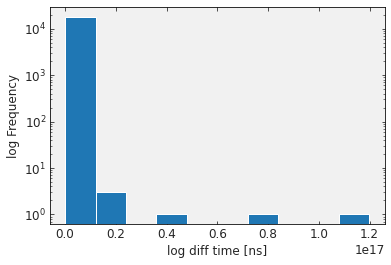

In [31]:
# -- histogram of the difference in nanoseconds
# plt.hist(arrr, log=True)
eqGoodData["dts1"].plot(kind="hist", logy=True)
pl.xlabel("log diff time [ns]", fontsize = 12)
pl.ylabel("log Frequency", fontsize = 12)
pl.plot()

The thing that worries me is that by removing some sections of the data to use only stationary periods we created some artificially large gaps: gaps of order ~month. How many nanoseconds in a month? remove all gaps that are larger than about a month and see how the distribution looks (make another histogram).

In [32]:
# -- convert one month in nanoseconds
min_nanosecond = 1*30*24*60*60*1e9
# -- keep the data who's gap is smaller than nanosecond
eqGoodData = eqGoodData[(eqGoodData["dts1"] < min_nanosecond)]
# eqGoodData["dts"].dt.components
len(eqGoodData)

18016

[]

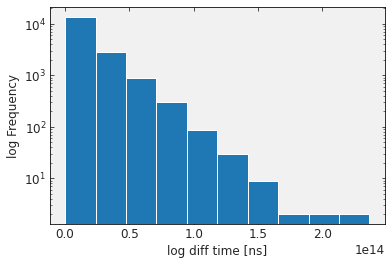

In [33]:
# -- histogram of the difference in nanoseconds
eqGoodData["dts1"].plot(kind="hist", logy=True)
pl.xlabel("log diff time [ns]", fontsize = 12)
pl.ylabel("log Frequency", fontsize = 12)
pl.plot()

# data analysis

### important: the paper does not do it but I want you to formally choose a threshold before you do this test. Choose a p-value (=$\alpha$ thresold: call your variable ```alpha```) of 3-$\sigma$.

Follow the instructions (algorithm) in **Section 3 paragraph 3** and compare your results with the results in table 1 with a threshold  of = 0.01 and 0.001

Do it for all 5 magnitude thresholds as indicated in the paper (and in Table 1).

Note that the x axis in plot Fig 1 is in _log space_. Use ```np.log10()``` to take the logarithm of the time gaps.

The pseudocode for the algorithm is [here](https://github.com/fedhere/DSPS/blob/master/HW3/Corral2018_pseudocode.md).


Reproduce the paper Fig 1 and Table 1. In the Table report the size of each dataset after cleaning the value of the statistic and the p-value, as done in Corral 2018. Use the scipy function for the 2 sample KS test. (resources [here](https://colab.research.google.com/notebooks/markdown_guide.ipynb#scrollTo=70pYkR9LiOV0) to learn about the table syntax in markdown)

In [34]:
mags = [2, 2.5, 3, 3.5, 4]
mm = [0.01, 0.03, 0.001, 0.003]

In [35]:
# your code here
eqGoodData_copy = eqGoodData.copy()
(eqGoodData_copy.mag >= mags[0]).sum()

18016

In [36]:
eqGoodData_mag2 = eqGoodData_copy[(eqGoodData_copy.mag >= mags[0])]
R = 1 / eqGoodData_mag2["dts1"].mean()
eqGoodData_mag2["rescale"] = eqGoodData_mag2["dts1"] * R
eqGoodData_mag2

,date,time,mag,datetime,dts,dts1,rescale
1,1984/01/01,05:31:34.16,2.12,1984-01-01 05:31:34.160,0 days 04:00:36.640000,1.443664e+13,0.888323
2,1984/01/01,06:59:05.14,2.43,1984-01-01 06:59:05.140,0 days 01:27:30.980000,5.250980e+12,0.323106
3,1984/01/01,11:10:25.29,2.07,1984-01-01 11:10:25.290,0 days 04:11:20.150000,1.508015e+13,0.927919
4,1984/01/01,19:38:19.79,2.13,1984-01-01 19:38:19.790,0 days 08:27:54.500000,3.047450e+13,1.875172
5,1984/01/01,19:39:19.67,2.13,1984-01-01 19:39:19.670,0 days 00:00:59.880000,5.988000e+10,0.003685
...,...,...,...,...,...,...,...
70793,2002/12/29,19:37:24.56,2.21,2002-12-29 19:37:24.560,0 days 00:00:30.140000,3.014000e+10,0.001855
70794,2002/12/29,20:17:33.40,2.02,2002-12-29 20:17:33.400,0 days 00:40:08.840000,2.408840e+12,0.148222
70795,2002/12/29,20:21:28.73,2.07,2002-12-29 20:21:28.730,0 days 00:03:55.330000,2.353300e+11,0.014480
70796,2002/12/30,21:51:52.55,2.31,2002-12-30 21:51:52.550,1 days 01:30:23.820000,9.182382e+13,5.650149


In [37]:
eqGoodData_mag2 = eqGoodData_mag2[eqGoodData_mag2["rescale"] > mm[0]]
eqGoodData_mag2

,date,time,mag,datetime,dts,dts1,rescale
1,1984/01/01,05:31:34.16,2.12,1984-01-01 05:31:34.160,0 days 04:00:36.640000,1.443664e+13,0.888323
2,1984/01/01,06:59:05.14,2.43,1984-01-01 06:59:05.140,0 days 01:27:30.980000,5.250980e+12,0.323106
3,1984/01/01,11:10:25.29,2.07,1984-01-01 11:10:25.290,0 days 04:11:20.150000,1.508015e+13,0.927919
4,1984/01/01,19:38:19.79,2.13,1984-01-01 19:38:19.790,0 days 08:27:54.500000,3.047450e+13,1.875172
6,1984/01/01,20:19:47.21,2.02,1984-01-01 20:19:47.210,0 days 00:40:27.540000,2.427540e+12,0.149373
...,...,...,...,...,...,...,...
70791,2002/12/29,19:36:07.23,3.15,2002-12-29 19:36:07.230,0 days 16:59:59.870000,6.119987e+13,3.765781
70794,2002/12/29,20:17:33.40,2.02,2002-12-29 20:17:33.400,0 days 00:40:08.840000,2.408840e+12,0.148222
70795,2002/12/29,20:21:28.73,2.07,2002-12-29 20:21:28.730,0 days 00:03:55.330000,2.353300e+11,0.014480
70796,2002/12/30,21:51:52.55,2.31,2002-12-30 21:51:52.550,1 days 01:30:23.820000,9.182382e+13,5.650149


In [38]:
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
# eqGoodData_mag2 = eqGoodData_copy[(eqGoodData_copy.mag >= mags[0])]
R = 1 / eqGoodData_mag2["rescale"].mean()
eqGoodData_mag2["rescale1"] = eqGoodData_mag2["rescale"] * R
eqGoodData_mag2

,date,time,mag,datetime,dts,dts1,rescale,rescale1
1,1984/01/01,05:31:34.16,2.12,1984-01-01 05:31:34.160,0 days 04:00:36.640000,1.443664e+13,0.888323,0.849032
2,1984/01/01,06:59:05.14,2.43,1984-01-01 06:59:05.140,0 days 01:27:30.980000,5.250980e+12,0.323106,0.308815
3,1984/01/01,11:10:25.29,2.07,1984-01-01 11:10:25.290,0 days 04:11:20.150000,1.508015e+13,0.927919,0.886878
4,1984/01/01,19:38:19.79,2.13,1984-01-01 19:38:19.790,0 days 08:27:54.500000,3.047450e+13,1.875172,1.792234
6,1984/01/01,20:19:47.21,2.02,1984-01-01 20:19:47.210,0 days 00:40:27.540000,2.427540e+12,0.149373,0.142766
...,...,...,...,...,...,...,...,...
70791,2002/12/29,19:36:07.23,3.15,2002-12-29 19:36:07.230,0 days 16:59:59.870000,6.119987e+13,3.765781,3.599222
70794,2002/12/29,20:17:33.40,2.02,2002-12-29 20:17:33.400,0 days 00:40:08.840000,2.408840e+12,0.148222,0.141666
70795,2002/12/29,20:21:28.73,2.07,2002-12-29 20:21:28.730,0 days 00:03:55.330000,2.353300e+11,0.014480,0.013840
70796,2002/12/30,21:51:52.55,2.31,2002-12-30 21:51:52.550,1 days 01:30:23.820000,9.182382e+13,5.650149,5.400245


In [39]:
eqGoodData_mag2 = eqGoodData_mag2[eqGoodData_mag2["rescale1"] > mm[0]]
eqGoodData_mag2

,date,time,mag,datetime,dts,dts1,rescale,rescale1
1,1984/01/01,05:31:34.16,2.12,1984-01-01 05:31:34.160,0 days 04:00:36.640000,1.443664e+13,0.888323,0.849032
2,1984/01/01,06:59:05.14,2.43,1984-01-01 06:59:05.140,0 days 01:27:30.980000,5.250980e+12,0.323106,0.308815
3,1984/01/01,11:10:25.29,2.07,1984-01-01 11:10:25.290,0 days 04:11:20.150000,1.508015e+13,0.927919,0.886878
4,1984/01/01,19:38:19.79,2.13,1984-01-01 19:38:19.790,0 days 08:27:54.500000,3.047450e+13,1.875172,1.792234
6,1984/01/01,20:19:47.21,2.02,1984-01-01 20:19:47.210,0 days 00:40:27.540000,2.427540e+12,0.149373,0.142766
...,...,...,...,...,...,...,...,...
70791,2002/12/29,19:36:07.23,3.15,2002-12-29 19:36:07.230,0 days 16:59:59.870000,6.119987e+13,3.765781,3.599222
70794,2002/12/29,20:17:33.40,2.02,2002-12-29 20:17:33.400,0 days 00:40:08.840000,2.408840e+12,0.148222,0.141666
70795,2002/12/29,20:21:28.73,2.07,2002-12-29 20:21:28.730,0 days 00:03:55.330000,2.353300e+11,0.014480,0.013840
70796,2002/12/30,21:51:52.55,2.31,2002-12-30 21:51:52.550,1 days 01:30:23.820000,9.182382e+13,5.650149,5.400245


In [40]:
eqGoodData_mag2["rescale1"].mean()

1.0010363930181059

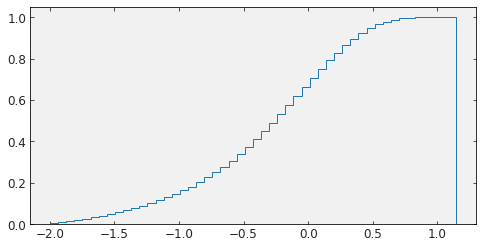

In [41]:
# np.log10(eqGoodData_mag2["rescale1"]).plot(kind = "hist")

# plot the cumulative histogram
fig, ax = plt.subplots(figsize=(8, 4))
n, bins, patches = ax.hist(np.log10(eqGoodData_mag2["rescale1"]), 50, density=True, histtype='step',
                           cumulative=True, label='Empirical')

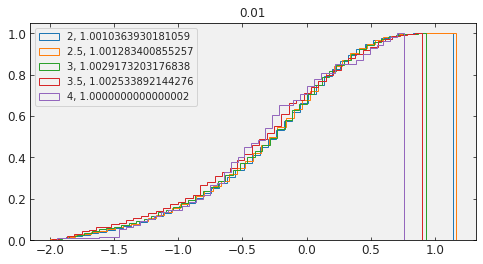

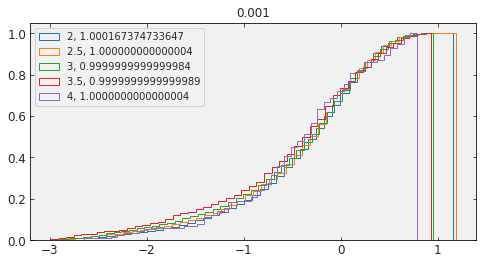

In [60]:
N = []
results = []

# eqGoodData_mag = pd.DataFrame()
for ii in [0.01, 0.001]:
  fig, ax = plt.subplots(figsize=(8, 4))
  for m in mags:
    eqGoodData_copy = eqGoodData.copy()
    # print(len(eqGoodData_copy))
    # N.append((eqGoodData_copy.mag >= m).sum())
    eqGoodData_mag = pd.DataFrame()
    eqGoodData_mag = eqGoodData_copy[(eqGoodData_copy.mag >= m)]
    # -- first
    # -- calculate the mean of the time gap
    R = 1 / eqGoodData_mag["dts1"].mean()
    # -- rescale the original gap
    eqGoodData_mag["rescale"] = eqGoodData_mag["dts1"] * R
    # -- keep time gaps greater than m = 0.01
    eqGoodData_mag = eqGoodData_mag[eqGoodData_mag["rescale"] >= ii]
    # print("first loop m = {}: {}".format(m, len(eqGoodData_mag)))
    N.append(len(eqGoodData_mag))

    # -- second
    R = 1 / eqGoodData_mag["rescale"].mean()
    eqGoodData_mag["rescale1"] = eqGoodData_mag["rescale"] * R
    eqGoodData_mag = eqGoodData_mag[eqGoodData_mag["rescale1"] >= ii]

    # print("second loop m = {}: {}".format(m, len(eqGoodData_mag)))
    N.append(len(eqGoodData_mag))
    results.append(eqGoodData_mag["rescale1"].to_numpy())
    # N.append((eqGoodData_mag.mag >= m).sum())
    # plot the cumulative histogram
    
    n, bins, patches = ax.hist(np.log10(eqGoodData_mag["rescale1"]), 50, density=True, histtype='step',
                              cumulative=True, label = "{}, {}".format(m, eqGoodData_mag["rescale1"].mean()))
    pl.legend(loc = "upper left")
    pl.title(ii)
    eqGoodData_mag = pd.DataFrame()

In [62]:
N

[17216,
 17198,
 5408,
 5401,
 1362,
 1358,
 392,
 391,
 109,
 109,
 17909,
 17906,
 5683,
 5683,
 1448,
 1448,
 423,
 423,
 115,
 115]

In [61]:
stats.ks_2samp(results[0], results[1])

Ks_2sampResult(statistic=0.011965444068570724, pvalue=0.5984467455711711)

In [51]:
stats.ks_2samp(results[0], results[2])

Ks_2sampResult(statistic=0.0201968890104528, pvalue=0.6835797052166797)

In [52]:
stats.ks_2samp(results[0], results[3])

Ks_2sampResult(statistic=0.06582577109275489, pvalue=0.07280227760550426)

In [53]:
stats.ks_2samp(results[0], results[4])

Ks_2sampResult(statistic=0.11047262803120911, pvalue=0.14213582878232112)

In [54]:
stats.ks_2samp(results[1], results[2])

Ks_2sampResult(statistic=0.011965444068570724, pvalue=0.5984467455711711)

In [55]:
stats.ks_2samp(results[1], results[3])

Ks_2sampResult(statistic=0.058441862854799555, pvalue=0.15887109976907143)

In [56]:
stats.ks_2samp(results[1], results[4])

Ks_2sampResult(statistic=0.10872604291763843, pvalue=0.1482883979287336)

In [57]:
stats.ks_2samp(results[2], results[3])

Ks_2sampResult(statistic=0.060475198595798696, pvalue=0.20670123199815182)

In [58]:
stats.ks_2samp(results[2], results[4])

Ks_2sampResult(statistic=0.11219278215400413, pvalue=0.14537814281024775)

In [59]:
stats.ks_2samp(results[3], results[4])

Ks_2sampResult(statistic=0.06797437762500293, pvalue=0.7952495835195914)

your table here

Did you find any statistical significant differences between the distributions? What does it mean? Is your result identical to Correll's 2018? Why or why not? **Discuss!**

### "extra credits"

**How could you _force_ a significant result?**
Organize your result for different magnitude threshold in a numpy array (it should be a 5x5 array) for both cutoffs (0.01 and 0.001). Each of these arrays should contain the p-value for the pair of distributions i,j in cell \[i\]\[j\] and \[j\]\[i\]. Use ```imshow``` to visualize this 2D data. FIrst visualize the matrix itself as done below.

In [ ]:
# your code here
        
pl.imshow((ks_001));
pl.axis('off')
cb = pl.colorbar()
cb.ax.set_ylabel(r'$p$-value')
pl.title("KS test results");
#add a caption

NameError: ignored


Now visualize the result as a matrix where the cells are white if the results is not statistically significant and red otherwise. 
After doing it fot the set alpha threshold, lower your alpha threshold so that at least one pair of distribution has a statistically significant difference. **Warning!! this is an _unethical and horrifying practice_! Once you chose your significance threshold you are never allowed to change it! Why? Discuss**

Redoing it for threshold 0001